# Generate Data for BioKGC on gene function prediction task

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(igraph)
library(ggthemes)
library(purrr)
options(repr.plot.width=3, repr.plot.height=3)
options(jupyter.plot_mimetypes = "image/svg+xml")


Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:data.table':

    between, first, last


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union



Attache Paket: 'igraph'


Die folgenden Objekte sind maskiert von 'package:dplyr':

    as_data_frame, groups, union


Die folgenden Objekte sind maskiert von 'package:stats':

    decompose, spectrum


Das folgende Objekt ist maskiert 'package:base':

    union



Attache Paket: 'purrr'


Die folgenden Objekte sind maskiert von 'package:igraph':

    compose, simplify


Das folgende Objekt ist maskiert 'package:data.table':

    transpose




## Inspect Pathway Commons

In [2]:
dir_raw="data/raw/"
dir_processed="data/processed/"
dir_output="data/output/"

In [3]:
PC_dt <- unique(fread(paste0(dir_raw, "PathwayCommons12.All.hgnc.sif"), header=FALSE))

In [4]:
dim(PC_dt); head(PC_dt)

[1] 1884157       3

V1,V2,V3
<chr>,<chr>,<chr>
A1BG,controls-expression-of,A2M
A1BG,interacts-with,ABCC6
A1BG,interacts-with,ACE2
A1BG,interacts-with,ADAM10
A1BG,interacts-with,ADAM17
A1BG,interacts-with,ADAM9


[1] "controls-expression-of"         "interacts-with"                
 [3] "controls-phosphorylation-of"    "controls-state-change-of"      
 [5] "in-complex-with"                "controls-production-of"        
 [7] "catalysis-precedes"             "controls-transport-of"         
 [9] "controls-transport-of-chemical" "chemical-affects"              
[11] "consumption-controlled-by"      "used-to-produce"               
[13] "reacts-with"

                                V2      N     sum
 1:               chemical-affects 618094 1884157
 2:                 interacts-with 517391 1884157
 3:       controls-state-change-of 191548 1884157
 4:                in-complex-with 191275 1884157
 5:             catalysis-precedes 147948 1884157
 6:         controls-expression-of 125860 1884157
 7:      consumption-controlled-by  22659 1884157
 8:         controls-production-of  21262 1884157
 9:    controls-phosphorylation-of  17660 1884157
10:                used-to-produce  14757 1884157
11:          controls-transport-of   7899 1884157
12:                    reacts-with   4063 1884157
13: controls-transport-of-chemical   3741 1884157


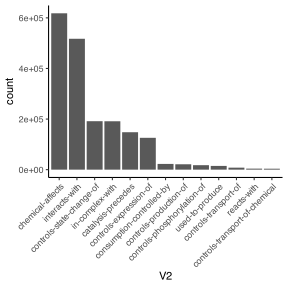

In [5]:

options(repr.plot.width=4, repr.plot.height=4)
unique(PC_dt$V2)

dt <- PC_dt[,.N, by=V2][order(-N)][, sum:=sum(N)]
idorder <- dt[order(-N), V2]
PC_dt$V2 <- factor(PC_dt$V2, level=idorder)

ggplot(PC_dt, aes(x=V2)) + geom_bar() + theme_classic() +theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

print(dt)

## Format KEGG data

In [6]:
cpdb <- fread(paste0(dir_raw, "CPDB_pathways_genes.tab"))
kegg_raw <- cpdb[source=="KEGG"]
kegg_p <- tidyr::separate(
  kegg_raw,
  hgnc_symbol_ids,
    into=c(paste0("g_", 1:600)),
  sep = ",")
kegg_p_m <- data.table(melt(kegg_p, id.vars=c("pathway","external_id", "source"), value.name = "gene"))
kegg_p_m <- na.omit(kegg_p_m)
kegg_p_m[,source:=NULL]
kegg_p_m[,variable:=NULL]
kegg_p_m$external_id <- gsub("path:", "", kegg_p_m$external_id)
kegg_p_m_raw <- kegg_p_m

Warning message:
"Expected 600 pieces. Missing pieces filled with `NA` in 333 rows [1, 2, 3, 4,
5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...]."
Warning message in melt(kegg_p, id.vars = c("pathway", "external_id", "source"), :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(kegg_p). In the next version, this warning will become an error."


In [7]:
fwrite(kegg_p_m, file=paste0(dir_processed,"kegg_processed.txt"), sep="\t")

### Inspect KEGG

#### Number of pathways per gene

gene,N
<chr>,<int>
MAPK3,112
MAPK1,112
PIK3CD,100
PIK3CA,100
PIK3CB,100
PIK3R3,98


Warning message in geom_histogram(stat = "count"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


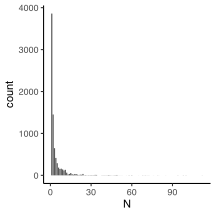

In [8]:
plt_dt <- kegg_p_m[,.N, by=gene][order(-N)];head(plt_dt)

options(repr.plot.width=3, repr.plot.height=3)
ggplot(plt_dt, aes(x=N)) +geom_histogram(stat="count") + theme_classic()

#### Number of genes per pathway

external_id,N
<chr>,<int>
hsa05200,531
hsa05168,498
hsa05022,475
hsa04740,440
hsa05010,369
hsa05014,364


Warning message in geom_histogram(stat = "count"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


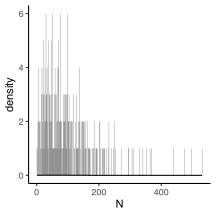

In [9]:
plt_dt <- kegg_p_m[,.N, by=external_id][order(-N)];head(plt_dt)

options(repr.plot.width=3, repr.plot.height=3)
ggplot(plt_dt, aes(x=N)) +geom_histogram(stat="count") + geom_density() + theme_classic()

#### Removal of all pathways with less than 10 associations

In [10]:
id <- kegg_p_m[,.N, by=.(external_id,pathway)][order(-N)][N>9, external_id]
kegg_p_m_rm <- kegg_p_m[external_id%in%id]
nrow(kegg_p_m)- nrow(kegg_p_m_rm)
nrow(kegg_p_m); nrow(kegg_p_m_rm)

[1] 62

[1] 32494

[1] 32432

## Fuse PC and KEGG

#### Create graph and extract biggest connected component

In [11]:
kegg_p_m_rm[, relation:="KEGGPathway"]

dt1 <- kegg_p_m_rm[,.(external_id, relation, gene)] %>% rename(u=external_id, r=relation, v=gene)
dt2 <- PC_dt[,.(V1, V2, V3)] %>% rename(u=V1, r=V2, v=V3)

human_PC_kegg <- rbind(dt1, dt2)
dim(human_PC_kegg);head(human_PC_kegg)

[1] 1916589       3

u,r,v
<chr>,<fct>,<chr>
hsa00250,KEGGPathway,NIT2
hsa00790,KEGGPathway,PCBD2
hsa04610,KEGGPathway,F8
hsa00020,KEGGPathway,PCK2
hsa04614,KEGGPathway,ACE
hsa05340,KEGGPathway,IL7R


In [12]:
#human_PC_kegg_e <- human_PC_kegg[!(r=="in-complex-with")]
g <- graph_from_data_frame(human_PC_kegg[,.(u,v,r)], directed=TRUE)
dg <- decompose.graph(g)
net <- as.data.table(as_data_frame(dg[[1]], what = "edges"))

In [13]:
# number of nodes in each disconnected subgraph
head(clusters(g)$csize)

[1] 31468     2     2     2     2     3

## Data Split

Split data into train1, train2, vaild and test.

- train1: BRG - all edges that are not between gene/chemical and KEGG pathway for message passing
- train2: training edges between gene/chemical and KEGG pathway
- valid: validation edges between gene/chemical and KEGG pathway
- test: test edges between gene/chemical and KEGG pathway

In [14]:
net <-  net[,.(from, r, to)]
head(net)

from,r,to
<chr>,<chr>,<chr>
hsa00250,KEGGPathway,NIT2
hsa00790,KEGGPathway,PCBD2
hsa04610,KEGGPathway,F8
hsa00020,KEGGPathway,PCK2
hsa04614,KEGGPathway,ACE
hsa05340,KEGGPathway,IL7R


In [15]:
dim(net)
k_net <- unique(net[r=="KEGGPathway"]); dim(k_net)
b_net <- unique(net[!(r=="KEGGPathway")]); dim(b_net)

[1] 1916578       3

[1] 32432     3

[1] 1884146       3

In [16]:
nodes <- unique(c(b_net$from, b_net$to))
chem <- nodes[(grep("CHEBI",nodes))]
length(nodes[!(nodes%in%chem)])
nrow(unique(b_net))

[1] 19554

[1] 1884146

In [17]:
train_num <- as.integer(nrow(k_net)*0.7)
valid_num <- as.integer(nrow(k_net)*0.1)
test_num <- nrow(k_net) - train_num - valid_num
print(paste0("Number of edges in fact graph: ", nrow(b_net)))
print(paste0("Number of edges in train data KEGG: ", train_num))
print(paste0("Number of edges in valid data KEGG: ", valid_num))
print(paste0("Number of edges in test data KEGG: ", test_num))

[1] "Number of edges in fact graph: 1884146"
[1] "Number of edges in train data KEGG: 22702"
[1] "Number of edges in valid data KEGG: 3243"
[1] "Number of edges in test data KEGG: 6487"


In [18]:
set.seed(123)
# shuffle only KEGG
hbk_shuff <- k_net[sample(1:nrow(k_net)), ]; head(hbk_shuff)

from,r,to
<chr>,<chr>,<chr>
hsa04926,KEGGPathway,GNG10
hsa04146,KEGGPathway,PIPOX
hsa04530,KEGGPathway,MSN
hsa04072,KEGGPathway,INSR
hsa05205,KEGGPathway,GPC1
hsa05322,KEGGPathway,H3-3B


In [20]:
# train KEGG
hbk_train <- hbk_shuff[1:train_num]
# valid KEGG
hbk_valid <- hbk_shuff[(train_num+1):(train_num+valid_num)]
# test KEGG
hbk_test <- hbk_shuff[(train_num+valid_num+1):(train_num+valid_num+test_num)]

set.seed(123)
b_net_train <- b_net[sample(1:nrow(b_net)), ]; head(b_net)

dim(b_net_train);dim(hbk_train); dim(hbk_valid); dim(hbk_test)

from,r,to
<chr>,<chr>,<chr>
A1BG,controls-expression-of,A2M
A1BG,interacts-with,ABCC6
A1BG,interacts-with,ACE2
A1BG,interacts-with,ADAM10
A1BG,interacts-with,ADAM17
A1BG,interacts-with,ADAM9


[1] 1884146       3

[1] 22702     3

[1] 3243    3

[1] 6487    3

##### Make sure KEGG pathways in valid and test are also in train

In [21]:

t_v <- unique(hbk_test$from)
v_v <- unique(hbk_valid$from)
tr_v <- unique(hbk_train$from)

print(paste0("Number of pathways in test: ", length(t_v)))
print(paste0("Number of pathways in valid: ", length(v_v)))
print(paste0("Number of pathways in train: ", length(tr_v)))

#tr_v[!(tr_v%in%t_v)]
t_v[!(t_v%in%tr_v)]

[1] "Number of pathways in test: 319"


[1] "Number of pathways in valid: 318"
[1] "Number of pathways in train: 321"


character(0)

##### Make sure KEGG-genes in valid and test are also in train


In [22]:

t_v <- unique(hbk_test$to)
v_v <- unique(hbk_valid$to)
tr_v <- unique(c(hbk_train$to, unique(c(b_net$from, b_net$to))))
length(t_v); length(v_v); length(tr_v); 

print(paste0("Number of genes in test: ", length(t_v)))
print(paste0("Number of genes in valid: ", length(v_v)))
print(paste0("Number of genes in train: ", length(tr_v)))


print(paste0("Number of genes in test but not in train: ", length(t_v[!(t_v%in%tr_v)])))
print(paste0("Number of genes in test but not in train: ", length(v_v[!(v_v%in%tr_v)])))

[1] 3257

[1] 2046

[1] 31089

[1] "Number of genes in test: 3257"
[1] "Number of genes in valid: 2046"
[1] "Number of genes in train: 31089"
[1] "Number of genes in test but not in train: 43"
[1] "Number of genes in test but not in train: 16"


##### Remove nodes in valid and test that are not in train1 or train2

In [23]:
true_inductive <- unique(c(t_v[!(t_v%in%tr_v)],v_v[!(v_v%in%tr_v)]))
hbk_valid <- hbk_valid[!(to%in%true_inductive)]
hbk_test <- hbk_test[!(to%in%true_inductive)]

print(paste0("Number of inductive genes removed from valid and test: ", length(true_inductive)))

print(paste0("Number of triplets in test: ", nrow(hbk_test)))
print(paste0("Number of triplets in valid: ", nrow(hbk_valid)))
print(paste0("Number of triplets in train2: ", nrow(hbk_train)))
print(paste0("Number of triplets in train1: ", nrow(b_net_train)))

[1] "Number of inductive genes removed from valid and test: 58"
[1] "Number of triplets in test: 6438"
[1] "Number of triplets in valid: 3227"
[1] "Number of triplets in train2: 22702"
[1] "Number of triplets in train1: 1884146"


In [24]:
net_k <- rbind(hbk_test, hbk_valid, hbk_train)
length(unique(net_k$to))
nrow(net_k)

[1] 8000

[1] 32367

In [25]:
fwrite(b_net_train, file=paste0(dir_output, "train1.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_train, file=paste0(dir_output, "train2.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_valid, file=paste0(dir_output, "valid.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_test, file=paste0(dir_output, "test.txt"),col.names=FALSE,  sep="\t")

## Create other entity_types.txt and entity_names.txt

In [26]:
net <- rbind(hbk_test, hbk_valid, hbk_train, b_net_train)
all_genes <- unique(c(net[r=="KEGGPathway", to], net[!(r=="KEGGPathway"), to], net[!(r=="KEGGPathway"), from]))
genes_dt <- as.data.table(cbind(all_genes, all_genes)) 
colnames(genes_dt) <- c("V1", "V2")
nrow(genes_dt)

[1] 31089

In [27]:
all_kegg <- fread(file=paste0(dir_processed,"kegg_processed.txt"), sep="\t")
all_kegg$pathway <- gsub(" - Homo sapiens \\(human\\)", "", all_kegg$pathway)
my_kegg <- unique(all_kegg[external_id%in%net[r=="KEGGPathway", from],][,.(external_id, pathway)]) %>% rename(V1= external_id, V2=pathway)
head(my_kegg)

V1,V2
<chr>,<chr>
hsa00250,"Alanine, aspartate and glutamate metabolism"
hsa00790,Folate biosynthesis
hsa04610,Complement and coagulation cascades
hsa00020,Citrate cycle (TCA cycle)
hsa04614,Renin-angiotensin system
hsa05340,Primary immunodeficiency


In [28]:
dic_nodes <- unique(as.data.table(rbind( genes_dt, my_kegg)))
head(dic_nodes); tail(dic_nodes); dim(dic_nodes)

V1,V2
<chr>,<chr>
PDE3B,PDE3B
PNLIPRP1,PNLIPRP1
CANX,CANX
FARP2,FARP2
CREB1,CREB1
CALM2,CALM2


V1,V2
<chr>,<chr>
hsa00531,Glycosaminoglycan degradation
hsa00532,Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate
hsa00533,Glycosaminoglycan biosynthesis - keratan sulfate
hsa00534,Glycosaminoglycan biosynthesis - heparan sulfate / heparin
hsa04914,Progesterone-mediated oocyte maturation
hsa04340,Hedgehog signaling pathway


[1] 31410     2

In [29]:
compounds <- fread(file=paste0(dir_raw, "compounds.tsv"), header=TRUE)[,.(CHEBI_ACCESSION, NAME)][!(NAME=="null")]
dim(compounds)

[1] 168843      2

In [30]:
dic_nodes_com <- merge(dic_nodes, compounds, by.x="V1", by.y="CHEBI_ACCESSION", all.x=T)
dic_nodes_com[!(is.na(NAME)), V2:= NAME]
#dic_nodes_com[grep("CHEBI",dic_nodes_com$V1 )]
#dic_nodes_com[!(NAME=="null")]
fwrite(dic_nodes_com[,.(V1,V2)], file=paste0(dir_output, "entity_names.txt"), col.names=FALSE, sep="\t")

#### Node types

In [31]:
genes_dt[,V2:="genes"]
genes_dt[grep("CHEBI",genes_dt$V1), V2:="chem"]
my_kegg[,V2:="KEGG"]
node_types <- unique(as.data.table(rbind(genes_dt, my_kegg)))
node_types[,.N, by=V2]
node_types$V2 <- as.integer(as.factor(node_types$V2))-1
node_types[,.N, by=V2]

V2,N
<chr>,<int>
genes,19758
chem,11331
KEGG,321


V2,N
<dbl>,<int>
2,19758
1,11331
0,321


In [32]:
fwrite(node_types[order(V2)], file=paste0(dir_output, "entity_types.txt"), col.names=FALSE, sep="\t")

## Data Split for no_factgraph

In [33]:

t_v <- unique(hbk_test$to)
v_v <- unique(hbk_valid$to)
tr_v <- unique(c(hbk_train$to,hbk_train$from))
length(t_v); length(v_v); length(tr_v); 

print(paste0("Number of genes in test: ", length(t_v)))
print(paste0("Number of genes in valid: ", length(v_v)))
print(paste0("Number of genes in train: ", length(tr_v)))


print(paste0("Number of genes in test but not in train: ", length(t_v[!(t_v%in%tr_v)])))
print(paste0("Number of genes in valid but not in train: ", length(v_v[!(v_v%in%tr_v)])))

[1] 3214

[1] 2030

[1] 7070

[1] "Number of genes in test: 3214"
[1] "Number of genes in valid: 2030"
[1] "Number of genes in train: 7070"
[1] "Number of genes in test but not in train: 856"
[1] "Number of genes in valid but not in train: 474"


In [34]:
true_inductive <- unique(c(t_v[!(t_v%in%tr_v)],v_v[!(v_v%in%tr_v)]))
hbk_valid <- hbk_valid[!(to%in%true_inductive)]
hbk_test <- hbk_test[!(to%in%true_inductive)]

print(paste0("Number of inductive genes removed from valid and test: ", length(true_inductive)))

print(paste0("Number of triplets in test: ", nrow(hbk_test)))
print(paste0("Number of triplets in valid: ", nrow(hbk_valid)))
print(paste0("Number of triplets in train2: ", nrow(hbk_train)))

[1] "Number of inductive genes removed from valid and test: 1251"
[1] "Number of triplets in test: 5502"
[1] "Number of triplets in valid: 2724"
[1] "Number of triplets in train2: 22702"


In [35]:
dir_output="/Users/yue.hu/Documents/proj/functionalannotation/KEGG/data/output/PC_KEGG_nofactgraph_2024-02-07/"
fwrite(b_net_train, file=paste0(dir_output, "train1.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_train, file=paste0(dir_output, "train2.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_valid, file=paste0(dir_output, "valid.txt"),col.names=FALSE,  sep="\t")
fwrite(hbk_test, file=paste0(dir_output, "test.txt"),col.names=FALSE,  sep="\t")

In [36]:
dt = rbind(hbk_train,hbk_valid,hbk_test)
dt_nodes = unique(c(dt$to, dt$from))

In [37]:

fwrite(dic_nodes_com[V1%in%dt_nodes][,.(V1,V2)], file=paste0(dir_output, "entity_names.txt"), col.names=FALSE, sep="\t")

In [38]:
fwrite(node_types[V1%in%dt_nodes][order(V2)], file=paste0(dir_output, "entity_types.txt"), col.names=FALSE, sep="\t")